# Find sequence embedding of human kinases in ChEMBL

This notebook collect sequence information of human kinases in ChEMBL (based on [Jaime Rodríguez-Guerra's script](https://github.com/openkinome/datascripts/blob/master/kinases-in-chembl/kinases_in_chembl.ipynb) and plot the embedding of human kinases by the [UniRep](https://www.nature.com/articles/s41592-019-0598-1) model implemented in [Tasks Assessing Protein Embeddings (TAPE)](https://github.com/songlab-cal/tape).

In [93]:
from pathlib import Path
import urllib.request
import pandas as pd
from tqdm import tqdm
import os
import numpy as np

### 1. Load all the human kinases in ChEMBL using [Jaime's code](https://github.com/openkinome/datascripts/blob/master/kinases-in-chembl/kinases_in_chembl.ipynb)

In [81]:
kinases = pd.read_csv("data/KinHubKinaseList.csv")
kinases

,xName,Manning Name,HGNC Name,Kinase Name,Group,Family,SubFamily,UniprotID
0,ABL1,ABL,ABL1,Tyrosine-protein kinase ABL1,TK,Abl,NaN,P00519
1,ACK,ACK,TNK2,Activated CDC42 kinase 1,TK,Ack,NaN,Q07912
2,ACTR2,ACTR2,ACVR2A,Activin receptor type-2A,TKL,STKR,STKR2,P27037
3,ACTR2B,ACTR2B,ACVR2B,Activin receptor type-2B,TKL,STKR,STKR2,Q13705
4,ADCK4,ADCK4,ADCK4,Uncharacterized aarF domain-containing protein...,Atypical,ABC1,ABC1-A,Q96D53
...,...,...,...,...,...,...,...,...
531,GTF2F1,GTF2F1,NaN,NaN,Atypical,GTF2F1,NaN,Q6IBK5
532,Col4A3BP,Col4A3BP,COL4A3BP,Collagen type IV alpha-3-binding protein,Atypical,Col4A3BP,NaN,Q9Y5P4
533,BLVRA,BLVRA,BLVRA,Biliverdin reductase A,Atypical,BLVRA,NaN,P53004
534,BAZ1A,BAZ1A,BAZ1A,Bromodomain adjacent to zinc finger domain pro...,Atypical,BAZ,NaN,Q9NRL2


In [82]:
CHEMBL_VERSION = "chembl_27"
url = fr"ftp://ftp.ebi.ac.uk/pub/databases/chembl/ChEMBLdb/releases/{CHEMBL_VERSION}/chembl_uniprot_mapping.txt"

In [83]:
with urllib.request.urlopen(url) as response:
    uniprot_map = pd.read_csv(response, sep="\t", skiprows=[0], names=["UniprotID", "chembl_targets", "sequence", "type"])
uniprot_map

,UniprotID,chembl_targets,sequence,type
0,P21266,CHEMBL2242,Glutathione S-transferase Mu 3,SINGLE PROTEIN
1,O00519,CHEMBL2243,Anandamide amidohydrolase,SINGLE PROTEIN
2,P19217,CHEMBL2244,Estrogen sulfotransferase,SINGLE PROTEIN
3,P97292,CHEMBL2245,Histamine H2 receptor,SINGLE PROTEIN
4,P17342,CHEMBL2247,Atrial natriuretic peptide receptor C,SINGLE PROTEIN
...,...,...,...,...
11779,Q91ZR5,CHEMBL3886121,Cation channel sperm-associated protein 1,SINGLE PROTEIN
11780,P48763,CHEMBL3886122,Sodium/hydrogen exchanger 2,SINGLE PROTEIN
11781,Q9UKU6,CHEMBL3886123,Thyrotropin-releasing hormone-degrading ectoen...,SINGLE PROTEIN
11782,Q9JJH7,CHEMBL3886124,Transient receptor potential cation channel su...,SINGLE PROTEIN


In [84]:
merged = pd.merge(kinases, uniprot_map[["UniprotID", "chembl_targets", "type"]], on='UniprotID')

### 2. Output all 466 kinase sequences into FASTA

In [88]:
with open('chembl_kinase_seq.fasta','wb') as file:
    for uniprot_id in tqdm(list(set(merged.UniprotID.tolist()))):
        url = f"https://www.uniprot.org/uniprot/{uniprot_id}.fasta"
        with urllib.request.urlopen(url) as response:
            seq = str()
            for line_number, line in enumerate(response):
                line = line.decode()
                if line[0] != '>':
                    seq += line.strip('\n')
            file.write(b'>'+uniprot_id.encode()+b'\n')
            file.write(seq.encode()+b'\n')
            file.write(b'\n')

100%|██████████| 466/466 [01:00<00:00,  7.72it/s]


### 3. Enbem all kinase sequences with the [UniRep babbler-1900 model](https://www.nature.com/articles/s41592-019-0598-1), as incorporated in [Tasks Assessing Protein Embeddings (TAPE)](https://github.com/songlab-cal/tape).   

In [92]:
os.system('tape-embed unirep chembl_kinase_seq.fasta unirep_kinase.npz babbler-1900 --tokenizer unirep')

0

In [150]:
arrays = np.load('unirep_kinase.npz', allow_pickle=True)

In [151]:
#print(list(arrays.keys()))  # Will output the name of the keys in your fasta file (or if unnamed then '0', '1', ...)

In [194]:
arrays['P07333'] # Returns a dictionary with keys 'pooled' and 'avg', (or 'seq' if using the --full_sequence_embed flag)

array({'pooled': array([ 0.47064018, -0.7947617 , -0.76075447, ...,  5.661771  ,
        4.832404  ,  2.3330503 ], dtype=float32), 'avg': array([ 0.00796701, -0.1440448 ,  0.09566606, ...,  0.15311624,
        0.06413095,  0.00679516], dtype=float32)}, dtype=object)

In [190]:
print("Number of unique kinase sequences: ", len(arrays))

Number of unique kinase sequences:  466


In [192]:
print("Dimension of the pooled embedding: ", len(arrays['P07333'].tolist()['pooled']))

Dimension of the pooled embedding:  3800


In [193]:
print("Dimension of the averaged embedding: ", len(arrays['P07333'].tolist()['avg']))

Dimension of the averaged embedding:  1900


#### Euclidean distance between two randomly selected kinase sequences ("Ephrin type-B receptor 4" and "ABL1"):

In [215]:
np.linalg.norm(arrays['P54760'].tolist()['avg'] - arrays['P00519'].tolist()['avg'])

4.2378035

#### Euclidean distance between EGFR and HER2 (from same family):

In [199]:
np.linalg.norm(arrays['P00533'].tolist()['avg'] - arrays['P04626'].tolist()['avg'])

0.7241786

#### As negative control, also import the embedding of some non-kinase proteins (e.g. 126 human ligases from UniProt as shown here).

In [ ]:
os.system('tape-embed unirep human_ligases.fasta unirep_ligase.npz babbler-1900 --tokenizer unirep')

In [245]:
ligase_arrays = np.load('unirep_ligase.npz', allow_pickle=True)

In [250]:
#print(list(ligase_arrays.keys()))

#### Euclidean distance between a randomly selected ligase and a kinase sequence ("Ephrin type-B receptor 4" and "ABL1"):

In [243]:
np.linalg.norm(ligase_arrays['sp|Q6ZT98|TTLL7_HUMAN'].tolist()['avg'] - arrays['P00519'].tolist()['avg'])

4.0277777

#### Compute the pairwise Euclidean distance between all kinase sequences:

In [228]:
kinase_embedding = np.zeros((466, 1900))
count = 0
for uniprot_id in tqdm(list(set(merged.UniprotID.tolist()))):
    kinase_embedding[count] = arrays[uniprot_id].tolist()['avg']
    count += 1

100%|██████████| 466/466 [00:00<00:00, 2457.09it/s]


In [229]:
kinase_embedding.shape

(466, 1900)

In [230]:
from sklearn.metrics import pairwise

In [244]:
kinase_pair_distance = pairwise.euclidean_distances(kinase_embedding) # compute pairwise distances
kinase_unique = np.triu(kinase_pair_distance)
rows1, cols1 = np.nonzero(kinase_unique)

#### Compute the pairwise Euclidean distance between all kinase sequences and ligases:

In [252]:
ligase_embedding = np.zeros((126, 1900))
count = 0
for uniprot_id in tqdm(list(ligase_arrays.keys())):
    ligase_embedding[count] = ligase_arrays[uniprot_id].tolist()['avg']
    count += 1

100%|██████████| 126/126 [00:00<00:00, 2097.45it/s]


In [241]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

In [259]:
KL_pair_distance = pairwise.euclidean_distances(kinase_embedding, ligase_embedding) # compute pairwise distances
rows2, cols2 = np.nonzero(KL_pair_distance)

(array([1.2000e+01, 7.6000e+01, 2.0400e+02, 4.2200e+02, 1.0580e+03,
        2.1560e+03, 4.5220e+03, 9.8520e+03, 1.3437e+04, 1.1182e+04,
        8.1020e+03, 4.2200e+03, 1.8370e+03, 5.4000e+02, 1.8000e+02,
        3.3700e+02, 4.0100e+02, 1.2800e+02, 3.5000e+01, 1.5000e+01]),
 array([1.26686083, 1.65796592, 2.04907101, 2.4401761 , 2.8312812 ,
        3.22238629, 3.61349138, 4.00459647, 4.39570157, 4.78680666,
        5.17791175, 5.56901684, 5.96012194, 6.35122703, 6.74233212,
        7.13343721, 7.5245423 , 7.9156474 , 8.30675249, 8.69785758,
        9.08896267]),
 <a list of 20 Patch objects>)

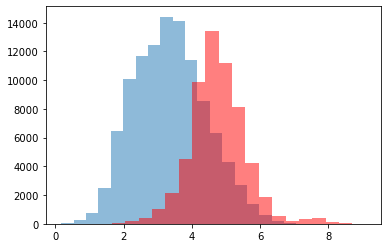

In [261]:
plt.hist(list(kinase_unique[rows1, cols1]), bins=20, alpha=0.5)
plt.hist(list(KL_pair_distance[rows2, cols2]), bins=20, color='r', alpha=0.5)